# Custom Effects

REBOUNDx is an all-or-nothing proposition.  Either you use it for all additional effects, or none.  This is because behind the scenes, REBOUNDx is setting REBOUND's `additional_forces` function pointer--so if you use REBOUNDx to, e.g., include general relativity corrections, and then define a custom force that you set with

`sim.additional_forces = custom_force`

like in REBOUND's [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb) ipython example, then you're overwriting the function pointer and only your effect will show up.

The ideal solution would be to write your function in C, and include it in REBOUNDx itself, following the instructions in this [page](http://reboundx.readthedocs.org/en/latest/add_effect.html) of the documentation. 

This will be faster by a factor of a few since everything can happen in C (rather than having to switch and call your function in Python every timestep), and would help grow the library of effects in REBOUNDx (and get you citations to your paper when people use your implementation!).

However, it is useful to be able to get things running quick and dirty in cases where it's a one-off thing or just to quickly test the implementation before doing it the "right" way.  We first add a custom force to include in the integration, and then a custom function to execute between integrator timesteps (post-timestep modification).

# Adding a Custom Force

This example parallels REBOUND's [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb) example, which implements a Python function for calculating the simple Stark force, showing how to add it to REBOUNDx (again, you would do this so that you could use other REBOUNDx effects at the same time).  See the original notebook for context of the force itself--this just shows the method.

In [1]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()  # Moves to the center of momentum frame

We now define our function that updates our particle accelerations.  We also define a flag for whether our force depends on the particle velocities or not, which we'll need to pass to REBOUNDx in order to get accurate behavior.

In [2]:
force_is_velocity_dependent = False
def starkForce(reb_sim, rebx_effect, particles, N):
    sim = reb_sim.contents # Under the hood all functions take a pointer to the simulation and effect.  This gives us the actual structures.
    effect = rebx_effect.contents
    
    try:
        particles[1].ax += effect.params["c"] # make sure you update the accelerations in particles, not sim.particles 
    except AttributeError:
        raise RuntimeError("Need to set c parameter for custom starkForce routine")

Note that this looks different from an additional force in REBOUND.  In addition to passing the simulation, you also have to pass a `rebx_effect`, a `particles` array and the number of particles `N` in it.  The effect structure allows us to add and read parameters from the corresponding effect structure.  Above we use a try except block to check whether the user has remembered to set the `c` parameter.

Now we add REBOUNDx just like we would normally do, and add the custom force, passing it our flag that says whether the force is velocity dependent.

In [3]:
import reboundx
rebx = reboundx.Extras(sim)
custom_effect = rebx.add_custom_force(starkForce, force_is_velocity_dependent)

We wrote our function to read a parameter `c` from our effect, so we need to set it before integrating:

In [4]:
custom_effect.params["c"] = 0.01

Now we can just integrate as usual. Comparing the output between this and [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb), it is the same.

In [5]:
import numpy as np
Nout = 1000
es = np.zeros(Nout)
times = np.linspace(0.,100.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    es[i] = sim.particles[1].e 

And let's plot the result.

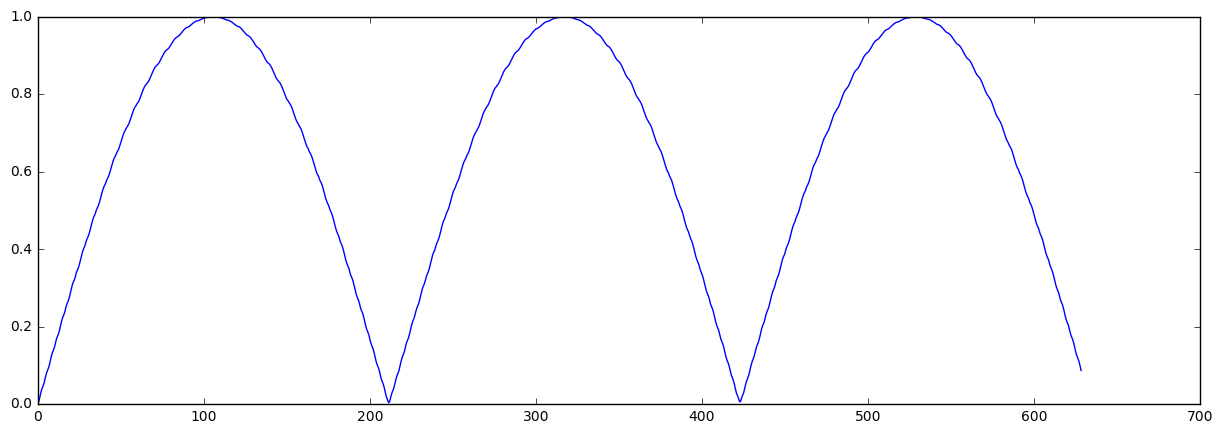

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
plt.xlabel="time"
plt.plot(times, es);

# Adding a Custom Post-Timestep Modification

This looks very similar to what we did above, but now this function is executed between integrator timesteps, rather than including a custom force in addition to point source gravity as above.

In [7]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()  # Moves to the center of momentum frame

Now we define a simple function that adds mass to `particles[1]` between timesteps.  Note that if this is all you want to do, you probably should use the `modify_mass` effect that's already in REBOUNDx, since that will be substantially faster (since it's doing everything in C and not switching back and forth to call your Python function).  If you haven't, read the description of the custom force above, since all the same points apply here.

In [8]:
def add_mass(reb_sim, rebx_effect, dt, timing):
    sim = reb_sim.contents
    Mdot = 1.e-6 # hard-coded.  Could read a user-set parameter as done above
    sim.particles[1].m += Mdot*dt

Now we add REBOUNDx as usual, and add our function.  In contrast to the example in the previous section, we don't have to pass a `force_is_velocity_dependent` flag (because we're not adding a force!).

In [9]:
import reboundx
rebx = reboundx.Extras(sim)
custom_operator = rebx.add_custom_operator(add_mass)

Now if we integrate and plot the mass of `particles[1]`, we see that our function is getting called, since the mass grows linearly with time.

In [10]:
import numpy as np
Nout = 1000
ms = np.zeros(Nout)
times = np.linspace(0.,10.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    ms[i] = sim.particles[1].m 

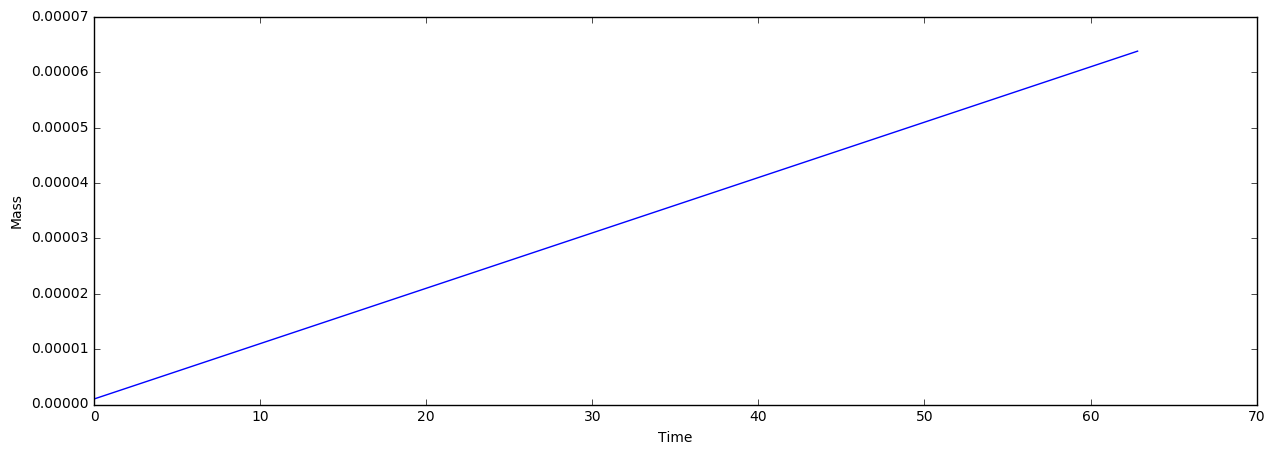

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_xlabel("Time")
ax.set_ylabel("Mass")
ax.plot(times, ms);